In [1]:
import pandas as pd
import os
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import StandardScaler
import copy
from torch.utils.data import DataLoader,  TensorDataset
from sklearn.utils import shuffle
import torch.nn as nn
import torch.nn.functional as F
import torch
from sklearn import linear_model
from sklearn import model_selection
from torchsummary import summary
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import dc_library as dcl

In [2]:
object_table = dcl.load_table(have_images = True)

table has 446487 sources
class
Gal         246225
Star         96715
Qso          83130
Agn           5608
highZQso      1089
Name: count, dtype: int64
Keeping 432767 labeled sources
Keeping 142963 with all features used in Savic+23
Keeping 142855 with available cutouts


In [3]:
object_table, validation_table = train_test_split(object_table, test_size = 0.1, random_state= 2121805)

In [4]:
X = object_table.drop(columns=["class", "label"])
y = object_table["label"].to_numpy().astype('int32')
objectID = object_table.index
X, y, objectID = shuffle(X, y, objectID, random_state = 2605)

In [5]:
X_train, X_test, y_train, y_test, objectID_train, objectID_test = train_test_split(X, y, 
                                objectID, test_size = 0.5, random_state = 1406)
scaler = StandardScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)
display(X_train.shape, X_test.shape)

(64284, 62)

(64285, 62)

In [6]:
images_train = dcl.load_images(objectID_train, as_tensor = True)
images_test = dcl.load_images(objectID_test, as_tensor = True)

In [7]:
X_train, y_train = dcl.transform2tensor(X_train, y_train)
X_test, y_test = dcl.transform2tensor(X_test, y_test)

In [8]:
class model_tabular(nn.Module):
    def __init__(self):
        super(model_tabular, self).__init__()
        
        self.tabular_savic_like = nn.Sequential(
                     nn.Linear(62, 62),
                     nn.ReLU(),
                     nn.Linear(62, 30))
        
    def forward(self, x):
        return self.tabular_savic_like(x)
    
class model_images(nn.Module):
    
    def __init__(self):
        super(model_images, self).__init__()
        
        self.dense_part = nn.Sequential(
                          nn.Linear(3*8*8, 30),
                          nn.ReLU(),
                          nn.Linear(30, 30))
        
    def forward(self, x):
        x = F.max_pool2d(x, kernel_size=2, stride=2)
        x = torch.flatten(x, 1)
        x = self.dense_part(x)
        return x
    
    
    

    
class combined_model(nn.Module):
    
    def __init__(self):
        super(combined_model,self).__init__()
        
        self.model_tabular = model_tabular()
        self.model_images = model_images()
        self.dense = nn.Linear(60, 3)
        
    def forward(self, images, tabular):
        
        images =  self.model_images(images)
        tabular = self.model_tabular(tabular)
        out = torch.concat([images, tabular], dim = 1)
        out = self.dense(out)
        return out          

In [9]:
summary(combined_model(), input_size =[(1,3,16,16), (1,62)])

Layer (type:depth-idx)                   Param #
├─model_tabular: 1-1                     --
|    └─Sequential: 2-1                   --
|    |    └─Linear: 3-1                  3,906
|    |    └─ReLU: 3-2                    --
|    |    └─Linear: 3-3                  1,890
├─model_images: 1-2                      --
|    └─Sequential: 2-2                   --
|    |    └─Linear: 3-4                  5,790
|    |    └─ReLU: 3-5                    --
|    |    └─Linear: 3-6                  930
├─Linear: 1-3                            183
Total params: 12,699
Trainable params: 12,699
Non-trainable params: 0


Layer (type:depth-idx)                   Param #
├─model_tabular: 1-1                     --
|    └─Sequential: 2-1                   --
|    |    └─Linear: 3-1                  3,906
|    |    └─ReLU: 3-2                    --
|    |    └─Linear: 3-3                  1,890
├─model_images: 1-2                      --
|    └─Sequential: 2-2                   --
|    |    └─Linear: 3-4                  5,790
|    |    └─ReLU: 3-5                    --
|    |    └─Linear: 3-6                  930
├─Linear: 1-3                            183
Total params: 12,699
Trainable params: 12,699
Non-trainable params: 0

In [10]:
train_dataset = TensorDataset(images_train, X_train, y_train)
test_dataset = TensorDataset(images_test, X_test, y_test)

train_dataloader = DataLoader(train_dataset, batch_size = 32, shuffle = True)
test_dataloader = DataLoader(test_dataset, batch_size = 32, shuffle = True)

In [11]:
def train_routine(dataloader, model,  loss_fn, optimizer):
    losses = []
    num_batches = len(dataloader)
    for batch, (images, tabular, labels) in enumerate(dataloader): #X[0] = tensor with features, X[1] = labels
        output = model(images, tabular)
        loss = loss_fn(output, labels)

        # Backpropagation
        optimizer.zero_grad()    # Clear the gradient
        loss.backward()          # Compute the gradient (??)
        optimizer.step()         # update model weights

        
        if batch == round(num_batches/2):
            losses.append(loss.item())

    return losses

def test_routine(dataloader, model, loss_fn, verbose = True):
    num_batches = len(dataloader)
    test_loss = 0
    model.eval() 
    with torch.no_grad():
        for images, tabular, labels in dataloader:
            output = model(images, tabular)
            test_loss += loss_fn(output, labels).item()

    test_loss /= num_batches
    model.train()
    if verbose:
        print(f" Avg test loss      : {test_loss:>8f}")

    return test_loss

    

In [12]:
modello_finale = combined_model()
EPOCHS = 250
SEED = 12
loss_fn = torch.nn.CrossEntropyLoss()  #torch.nn.CrossEntropyLoss
optimizer = torch.optim.SGD(modello_finale.parameters(), lr=0.0005)

In [13]:
train_loss = []
test_loss  = []
for t in range(EPOCHS):
    train_loss.append(train_routine(train_dataloader, modello_finale, loss_fn, optimizer))
    test_loss.append(test_routine(test_dataloader, modello_finale, loss_fn, verbose = True))
    print(f"Epoch {t}")
print("Done!")

 Avg test loss      : 0.735349
Epoch 0
 Avg test loss      : 0.305530
Epoch 1
 Avg test loss      : 0.185958
Epoch 2
 Avg test loss      : 0.148750
Epoch 3
 Avg test loss      : 0.131710
Epoch 4
 Avg test loss      : 0.121980
Epoch 5
 Avg test loss      : 0.115589
Epoch 6
 Avg test loss      : 0.111077
Epoch 7
 Avg test loss      : 0.107707
Epoch 8
 Avg test loss      : 0.105067
Epoch 9
 Avg test loss      : 0.102915
Epoch 10
 Avg test loss      : 0.101118
Epoch 11
 Avg test loss      : 0.099576
Epoch 12
 Avg test loss      : 0.098248
Epoch 13
 Avg test loss      : 0.097051
Epoch 14
 Avg test loss      : 0.095986
Epoch 15
 Avg test loss      : 0.095021
Epoch 16
 Avg test loss      : 0.094149
Epoch 17
 Avg test loss      : 0.093349
Epoch 18
 Avg test loss      : 0.092617
Epoch 19
 Avg test loss      : 0.091936
Epoch 20
 Avg test loss      : 0.091315
Epoch 21
 Avg test loss      : 0.090728
Epoch 22
 Avg test loss      : 0.090196
Epoch 23
 Avg test loss      : 0.089668
Epoch 24
 Avg test 

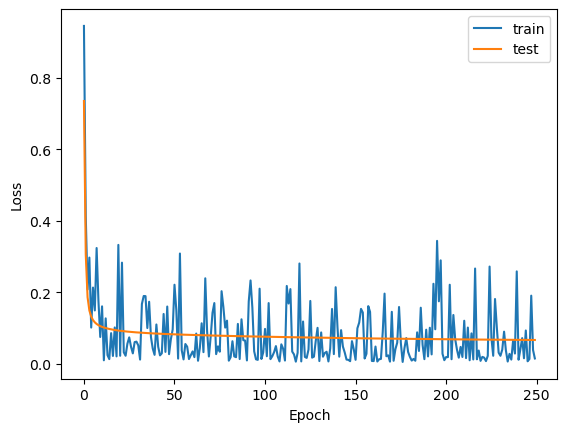

In [14]:
fig, ax = plt.subplots()
ax.plot(np.arange(0, EPOCHS,1), train_loss, label = "train")
ax.plot(np.arange(0, EPOCHS,1), test_loss, label = "test")
ax.set_xlabel("Epoch")
ax.set_ylabel("Loss")
ax.legend()

[0.99073928 0.98331812 0.95989467]
0.980850898343315


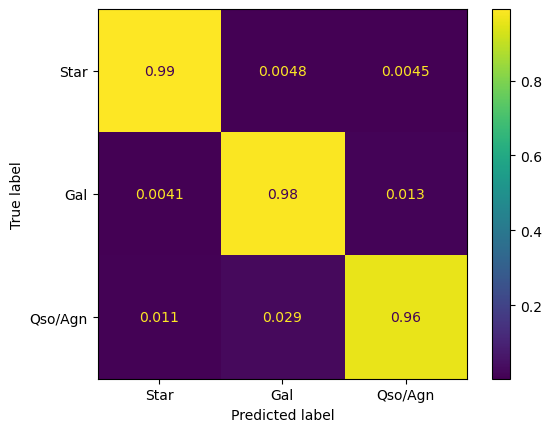

In [17]:
with torch.no_grad():
    predictions = modello_finale(images_test, X_test)
    predictions = predictions.detach().numpy()
predictions = np.argmax(predictions, axis =1)
cf = confusion_matrix(y_test, predictions, normalize = "true")

str_labels = ['Star', 'Gal', 'Qso/Agn']
accuracy = cf.diagonal()/cf.sum(axis=1)
print(accuracy)
print(accuracy_score(y_test, predictions))
ConfusionMatrixDisplay(cf, display_labels=str_labels).plot()


In [18]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Layer, InputSpec, Conv2D, MaxPooling2D, Flatten
from tensorflow.keras import backend as K
from tensorflow.keras.optimizers import SGD

2023-10-26 10:44:20.341888: I tensorflow/core/util/port.cc:111] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-10-26 10:44:20.626037: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-10-26 10:44:21.570047: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-10-26 10:44:21.570311: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-10-26 10:44:21.575060: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to regi

In [19]:
X_train_image = torch.permute(images_train, (0, 2,3, 1)).numpy()
X_test_image = torch.permute(images_test, (0, 2,3, 1)).numpy()
                              
                        


input_shape = X_train_image.shape[1:]

lay1_input = Input(shape=input_shape)
lay1 = MaxPooling2D((2, 2))(lay1_input)
lay1 = Flatten()(lay1)
lay1 = Dense(30, activation='relu')(lay1)
lay1_enc = Dense(30, activation='relu')(lay1)
lay1 = Dense(3, activation='sigmoid')(lay1_enc)
model_dense = Model(lay1_input, lay1)

display(model_dense.summary())

model_dense.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

num_epochs = 25
history = model_dense.fit(X_train_image, y_train.numpy(), epochs=num_epochs)
scores = model_dense.evaluate(X_test_image, y_test.numpy(), verbose=0)
display(scores)

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 16, 16, 3)]       0         
                                                                 
 max_pooling2d (MaxPooling2  (None, 8, 8, 3)           0         
 D)                                                              
                                                                 
 flatten (Flatten)           (None, 192)               0         
                                                                 
 dense (Dense)               (None, 30)                5790      
                                                                 
 dense_1 (Dense)             (None, 30)                930       
                                                                 
 dense_2 (Dense)             (None, 3)                 93        
                                                             

None

Epoch 1/25


/home/ivanosaccheo/.local/lib/python3.11/site-packages/keras/src/backend.py:5729: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


2009/2009 [==============================] - 5s 2ms/step - loss: 0.3394 - accuracy: 0.8732
Epoch 2/25
2009/2009 [==============================] - 4s 2ms/step - loss: 0.2585 - accuracy: 0.9057
Epoch 3/25
2009/2009 [==============================] - 4s 2ms/step - loss: 0.2471 - accuracy: 0.9105
Epoch 4/25
2009/2009 [==============================] - 4s 2ms/step - loss: 0.2384 - accuracy: 0.9126
Epoch 5/25
2009/2009 [==============================] - 4s 2ms/step - loss: 0.2304 - accuracy: 0.9172
Epoch 6/25
2009/2009 [==============================] - 4s 2ms/step - loss: 0.2247 - accuracy: 0.9194
Epoch 7/25
2009/2009 [==============================] - 4s 2ms/step - loss: 0.2214 - accuracy: 0.9203
Epoch 8/25
2009/2009 [==============================] - 4s 2ms/step - loss: 0.2181 - accuracy: 0.9208
Epoch 9/25
2009/2009 [==============================] - 4s 2ms/step - loss: 0.2164 - accuracy: 0.9220
Epoch 10/25
2009/2009 [==============================] - 4s 2ms/step - loss: 0.2136 - accurac

[0.2199493944644928, 0.921941339969635]

In [20]:
n_input_layer = X_train.shape[1]

tab_inputs = Input(n_input_layer)
tab_dense1 = Dense(n_input_layer, activation='relu')(tab_inputs)
tab_dense1 = Dense(30, activation='relu')(tab_dense1)
#tab_dense2 = Dense(3, activation='softmax')(tab_dense1)
model_tabular = Model(tab_inputs, tab_dense1)

display(model_tabular.summary())

model_tabular.compile(optimizer='adam',
                     loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                     metrics=['accuracy'])

history = model_tabular.fit(X_train.numpy(), y_train.numpy(), epochs=15)
scores = model_tabular.evaluate(X_test.numpy(), y_test.numpy(), verbose=0)
display(scores)

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 62)]              0         
                                                                 
 dense_3 (Dense)             (None, 62)                3906      
                                                                 
 dense_4 (Dense)             (None, 30)                1890      
                                                                 
Total params: 5796 (22.64 KB)
Trainable params: 5796 (22.64 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


None

Epoch 1/15
2009/2009 [==============================] - 3s 1ms/step - loss: 0.1525 - accuracy: 0.9652
Epoch 2/15
2009/2009 [==============================] - 3s 1ms/step - loss: 0.0671 - accuracy: 0.9804
Epoch 3/15
2009/2009 [==============================] - 3s 2ms/step - loss: 0.0620 - accuracy: 0.9815
Epoch 4/15
2009/2009 [==============================] - 3s 1ms/step - loss: 0.0588 - accuracy: 0.9821
Epoch 5/15
2009/2009 [==============================] - 3s 1ms/step - loss: 0.0563 - accuracy: 0.9830
Epoch 6/15
2009/2009 [==============================] - 3s 1ms/step - loss: 0.0547 - accuracy: 0.9835
Epoch 7/15
2009/2009 [==============================] - 3s 1ms/step - loss: 0.0534 - accuracy: 0.9835
Epoch 8/15
2009/2009 [==============================] - 3s 1ms/step - loss: 0.0516 - accuracy: 0.9846
Epoch 9/15
2009/2009 [==============================] - 3s 1ms/step - loss: 0.0508 - accuracy: 0.9842
Epoch 10/15
2009/2009 [==============================] - 3s 1ms/step - loss: 0.049

[0.06277401745319366, 0.9822664856910706]

In [21]:
concatenated = tf.keras.layers.concatenate([lay1_enc, tab_dense1]) # works better than convolutional

dense_class = Dense(3, activation='sigmoid')(concatenated) # final layer with 3 neurons for classification

model_concat = Model([lay1_input, tab_inputs], dense_class, name='model_concat')

display(model_concat.summary())

model_concat.compile(optimizer='adam',
                     loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                     metrics=['accuracy'])

Model: "model_concat"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 16, 16, 3)]          0         []                            
                                                                                                  
 max_pooling2d (MaxPooling2  (None, 8, 8, 3)              0         ['input_1[0][0]']             
 D)                                                                                               
                                                                                                  
 flatten (Flatten)           (None, 192)                  0         ['max_pooling2d[0][0]']       
                                                                                                  
 input_2 (InputLayer)        [(None, 62)]                 0         []                 

None

In [22]:
history = model_concat.fit([X_train_image, X_train.numpy()], y_train.numpy(), epochs=10)
scores = model_concat.evaluate([X_test_image, X_test.numpy()], y_test.numpy(), verbose=0)
display(scores)

Epoch 1/10
2009/2009 [==============================] - 5s 2ms/step - loss: 0.0979 - accuracy: 0.9705
Epoch 2/10
2009/2009 [==============================] - 4s 2ms/step - loss: 0.0485 - accuracy: 0.9852
Epoch 3/10
2009/2009 [==============================] - 4s 2ms/step - loss: 0.0452 - accuracy: 0.9862
Epoch 4/10
2009/2009 [==============================] - 4s 2ms/step - loss: 0.0429 - accuracy: 0.9868
Epoch 5/10
2009/2009 [==============================] - 4s 2ms/step - loss: 0.0411 - accuracy: 0.9874
Epoch 6/10
2009/2009 [==============================] - 4s 2ms/step - loss: 0.0389 - accuracy: 0.9881
Epoch 7/10
2009/2009 [==============================] - 4s 2ms/step - loss: 0.0380 - accuracy: 0.9884
Epoch 8/10
2009/2009 [==============================] - 4s 2ms/step - loss: 0.0365 - accuracy: 0.9883
Epoch 9/10
2009/2009 [==============================] - 4s 2ms/step - loss: 0.0357 - accuracy: 0.9884
Epoch 10/10
2009/2009 [==============================] - 4s 2ms/step - loss: 0.034

[0.06555768847465515, 0.9820953607559204]

In [27]:
predictionsavic = np.argmax(model_concat.predict([X_test_image, X_test.numpy()]), axis=1)

2009/2009 [==============================] - 3s 2ms/step


[0.99121217 0.98099427 0.96826683]
0.980850898343315


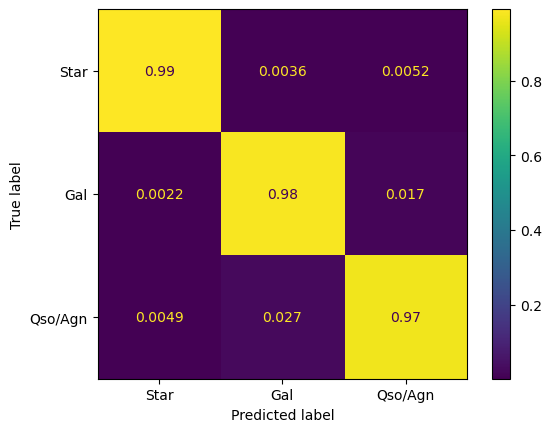

In [28]:
cf = confusion_matrix(y_test, predictionsavic, normalize = "true")

str_labels = ['Star', 'Gal', 'Qso/Agn']
accuracy = cf.diagonal()/cf.sum(axis=1)
print(accuracy)
print(accuracy_score(y_test, predictions))
ConfusionMatrixDisplay(cf, display_labels=str_labels).plot()